# **Figure 5.** Densities
## **Table 3.**
| Author  | Stanley A. Baronett |
|---------|---------------------|
| Created | 08/03/2022          |
| Updated | 09/23/2022          |

,Run,⟨max(𝜌ₚ)⟩ / 𝜌₀,-𝜎_max(𝜌ₚ) / 𝜌₀,+𝜎_max(𝜌ₚ) / 𝜌₀,⟨max(𝜌)⟩ / 𝜌₀,𝜎_max(𝜌) / 𝜌₀
0,AB/0.01,6.5e+01,-5.7e+01,+7.5e+01,1 + 6.4e+01,±1.2e+00
1,AB/0.02,6.1e+01,-5.3e+01,+6.9e+01,1 + 6.0e+01,±1.1e+00
2,AB/0.05,5.6e+01,-4.9e+01,+6.5e+01,1 + 5.5e+01,±1.2e+00
3,AB/0.10,5.4e+01,-4.7e+01,+6.3e+01,1 + 5.3e+01,±1.2e+00
4,BA/0.01,4.2e+02,-1.7e+02,+1.0e+03,1 + 4.2e+02,±2.4e+00
5,BA/0.02,4.0e+02,-1.6e+02,+1.0e+03,1 + 4.0e+02,±2.6e+00
6,BA/0.05,1.1e+02,-4.9e+01,+2.3e+02,1 + 1.0e+02,±2.2e+00
7,BA/0.10,2.6e+01,-2.0e+01,+3.3e+01,1 + 2.5e+01,±1.3e+00


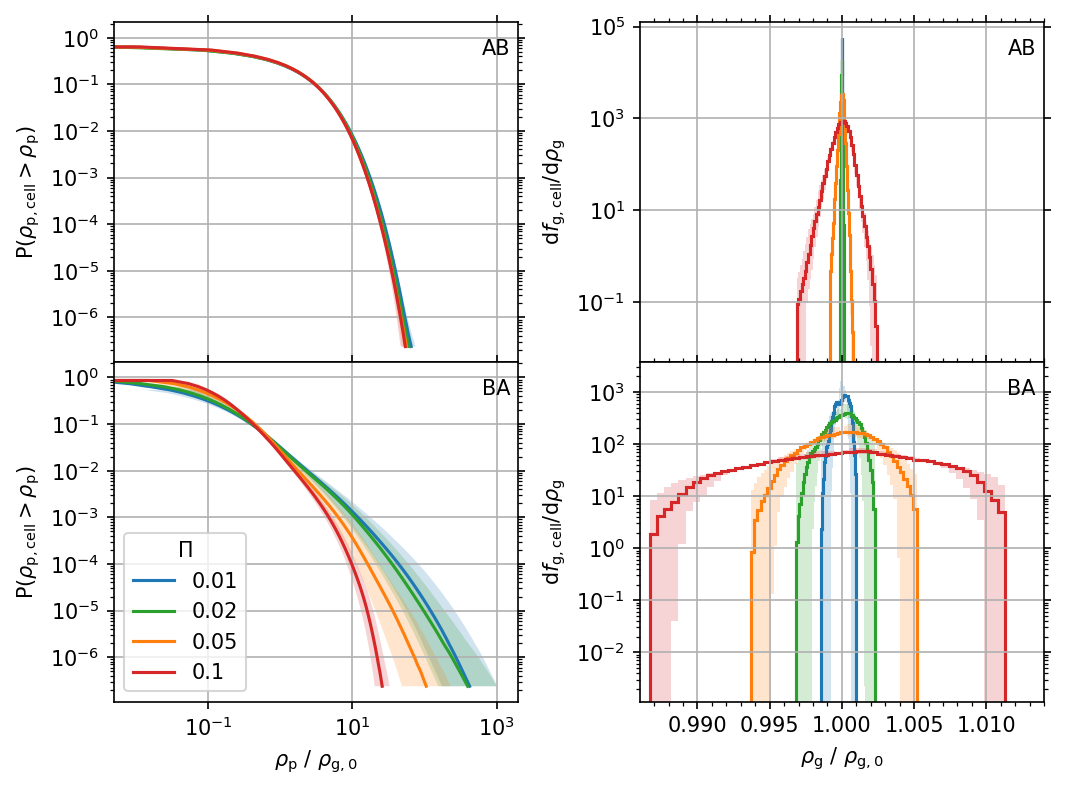

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axs = plt.subplots(2, 2, sharex='col', figsize=(8, 6),
                        dpi=150)
workdir = '../unstrat'
cases = ['AB', 'BA']
Pis = [['0.01', 'tab:blue'], ['0.02', 'tab:green'],
       ['0.05', 'tab:orange'], ['0.10', 'tab:red']]
res = '2048'
indices = -np.unique(np.logspace(np.log2(int(res)**2), 0, num=100,
                     base=2, dtype=int))
qtys = ['p', 'g']
runs, avg_maxs, err_maxs = [], [[], []], [[], []]

for i, case in enumerate(cases):
    for Pi in Pis:
        runs.append(f'{cases[i]}/{Pi[0]}')

        for j, qty in enumerate(qtys):
            data = np.load(f'{workdir}/{cases[i]}/{Pi[0]}/{res}/output/c{qty}dd.npz')
            if qty == 'p':
                take = np.take_along_axis(data['cdf'], indices, 0)
                cdf = np.flip(take)
                take = np.take_along_axis(data['avgs'], indices, 0)
                avgs = np.flip(take)
                take = np.take_along_axis(data['stds'], indices, 0)
                stds = np.flip(take)
                axs[i][j].loglog(avgs, cdf, color=Pi[1], label=float(Pi[0]))
                axs[i][j].fill_betweenx(cdf, avgs/stds, avgs*stds, color=Pi[1],
                                        ec=None, alpha=0.2)
            elif qty == 'g':
                avghist, bin_edges = np.histogram(data['avgs'], bins=50, density=True)
                lowhist, bin_edges = np.histogram(data['avgs']-data['stds'],
                                                  bins=bin_edges, density=True)
                highhist, bin_edges = np.histogram(data['avgs']+data['stds'],
                                                  bins=bin_edges, density=True)
                axs[i][j].stairs(avghist, bin_edges, color=Pi[1], lw=1.5)
                axs[i][j].stairs(highhist, bin_edges, baseline=lowhist, fill=True,
                                 color=Pi[1], alpha=0.2)
            avg_maxs[j].append(avgs[-1])
            err_maxs[j].append(stds[-1])

for ax in axs.flat:
    ax.grid()
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True)
    # ax.tick_params(axis='x', labelrotation=45)

axs[1][0].legend(loc='lower left', title=r'$\Pi$')
axs[0][0].set(ylabel=r'P$(\rho_\mathrm{p,cell}>\rho_\mathrm{p})$')
axs[0][1].set(yscale='log', ylabel=r'$\mathrm{d}f_\mathrm{g,cell}/\mathrm{d}\rho_\mathrm{g}$')
axs[1][0].set(xlim=(5e-3, 2e3),
              xlabel=r'$\rho_\mathrm{p}$ / $\rho_\mathrm{g,0}$',
              ylabel=r'P$(\rho_\mathrm{p,cell}>\rho_\mathrm{p})$')
axs[1][1].set(yscale='log', xlim=(0.986, 1.014),
              xlabel=r'$\rho_\mathrm{g}$ / $\rho_\mathrm{g,0}$',
              ylabel=r'$\mathrm{d}f_\mathrm{g,cell}/\mathrm{d}\rho_\mathrm{g}$')
axs[0][0].text(0.98, 0.95, cases[0], ha='right', va='top',
               transform=axs[0][0].transAxes)
axs[0][1].text(0.98, 0.95, cases[0], ha='right', va='top',
               transform=axs[0][1].transAxes)
axs[1][0].text(0.98, 0.95, cases[1], ha='right', va='top',
               transform=axs[1][0].transAxes)
axs[1][1].text(0.98, 0.95, cases[1], ha='right', va='top',
               transform=axs[1][1].transAxes)
plt.subplots_adjust(hspace=0, wspace=0.3)
plt.savefig('figs/densities.pdf', bbox_inches='tight', pad_inches=0.01)

df = pd.DataFrame({
    'Run'             : runs,
    '⟨max(𝜌ₚ)⟩ / 𝜌₀'   : avg_maxs[0],
    '-𝜎_max(𝜌ₚ) / 𝜌₀' : np.asarray(avg_maxs[0])/np.asarray(err_maxs[0]),
    '+𝜎_max(𝜌ₚ) / 𝜌₀' : np.asarray(avg_maxs[0])*np.asarray(err_maxs[0]),
    '⟨max(𝜌)⟩ / 𝜌₀'   : (np.asarray(avg_maxs[1]) - 1),
    '𝜎_max(𝜌) / 𝜌₀'  : err_maxs[1]})
s = df.style.format({
    '⟨max(𝜌ₚ)⟩ / 𝜌₀'   : '{:.1e}',
    '-𝜎_max(𝜌ₚ) / 𝜌₀' : '-{:.1e}',
    '+𝜎_max(𝜌ₚ) / 𝜌₀' : '+{:.1e}',
    '⟨max(𝜌)⟩ / 𝜌₀'   : '1 + {:.1e}',
    '𝜎_max(𝜌) / 𝜌₀'  : '±{:.1e}'})
s.to_latex(buf='tabs/densities.sty')
s